In [37]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger()
logger.setLevel(logging.INFO)

# For more output use DEBUG
# logger.setLevel(logging.DEBUG)

In [38]:
R_earth = 6371000
M_earth = 5.972e24
R_uranus = 3.979310 * R_earth #Nettelman 2013 U1
number_of_realisations = 50
surface_temperature = 5000  # Based On Nettelman 2013U1
planet_mass = 14.5322753*M_earth 

#defining now for different regions
core_mass = 0.5984897*M_earth #Nettelman 2013 U1
core_radius = 0.700034*R_earth
core_temperature = 6083.6 
#core_mass = 0.11*planet_mass  #Based on #https://arxiv.org/pdf/2412.06010
#r_core = 0.2*R_uranus  # Nettelman 2013

#now for MEB, based on Kaustub mass-relation for rocky planets R_P = 1.02*M_earth^0.252 = 2 R_earth
MBE_radius = 2*R_earth 
MBE_temperature = 4500 # https://www.pnas.org/doi/10.1073/pnas.2403981121
MBE_mass = 0.36*planet_mass # https://www.pnas.org/doi/10.1073/pnas.2403981121

#region of full mantle, boundary between inner and outer envelope
boundary_radius = 0.772*R_uranus #Nettelman 2013 U1
boundary_temperature = 2338.8
boundary_mass = 0.913*planet_mass #Nettelman 2013 U1


mantle_melt_fraction = 1.0  # 0.1 -> we will iterate 
planet_mass = boundary_mass
RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

In [39]:
H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07
Mg_masspercent_lodders09: float = 0.06

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53
Mg_logN: float = 7.54 

In [40]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
core_mass_fraction: float = 0.327  # typical values used are between 0.325 - 0.33
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme141: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999

MgO_mantlemasspercent_palme14: float = 36.77
Mg_massfraction_palme14: float = round(
    MgO_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (24.305 + 15.999)
    * 24.305,
    3,
)

O_massfraction_palme142: float = Si_massfraction_palme14 / 24.305 * 15.999
O_massfraction_palme14 = O_massfraction_palme141 + O_massfraction_palme142

In [41]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)

CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)

CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)

N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2", solubility=sol_models["N2_basalt_libourel03"], activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

Mg_g = Species.create_gas("Mg")
#Mg_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
#Mg_rgs = Species.create_gas(
#    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
#)

MgO_l = Species.create_condensed("MgO", state="l")
MgO_cr = Species.create_condensed("MgO", state="cr")
MgH_g = Species.create_gas("MgH")
MgOH_g = Species.create_gas("MgOH")

species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_g, CO_g, CH4_g, N2_g, NH3_g, He_g, Mg_g, MgO_l, MgH_g, MgOH_g)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_gs, CO_gs, CH4_gs, N2_gs, NH3_g, He_gs, Mg_g, MgO_l, MgH_g, MgOH_g)
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        CO2_rgs,
        CO_rgs,
        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs,
        Mg_g, 
        MgO_l,
        MgH_g,
        MgOH_g
    )
)
#MgH Magnesium Hydride
#MgOH Magnesium Hydroxide -> ideal gas law 
#Plot condensed moles for example for Silicon
#mass balance, take mass constraints, take atmospheric mass/moles+ take condensed mass/moles + take dissolved mass/moles
#plot envelope mass fraction, envelope mass/planet mass, Helled, what do they call the volatile layer. 
#temperature-pressure profile at 1 Myr or 10 Myr
#Ravit Helled 2011-2013

In [42]:
T_resolution = 20
H_resolution = 20 
#flatten look for numpy mesh, all condensates seperately
temperature = np.repeat(np.linspace(2000, 3000, T_resolution, endpoint=False), H_resolution)
temperature = temperature.flatten()
hmps = np.tile(np.logspace(-1, 0.5, num=H_resolution), int(np.ceil(T_resolution)))[:T_resolution*H_resolution]
hmps = hmps.flatten()

metall = 100
h_kgs = hmps / 100 * planet_mass
si_kg_magma: float = Si_massfraction_palme14 * planet_mass
mg_kg_magma: float = Mg_massfraction_palme14 * planet_mass
o_kg_magma: float = O_massfraction_palme14 * planet_mass

# Lodders et al. (2009) Springer book chapter Table 8
si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
mg_kgs_solar = h_kgs * Mg_masspercent_lodders09 / H_masspercent_lodders09
o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09
c_kgs_solar = h_kgs * C_masspercent_lodders09 / H_masspercent_lodders09
n_kgs_solar = h_kgs * N_masspercent_lodders09 / H_masspercent_lodders09
he_kgs_solar = h_kgs * He_masspercent_lodders09 / H_masspercent_lodders09

mass_constraints = {
    "H": h_kgs,
    "He": he_kgs_solar,
    "C": metall * c_kgs_solar,
    "N": metall * n_kgs_solar,
    "Si": metall * si_kgs_solar + mantle_melt_fraction * si_kg_magma,
    "O": metall * o_kgs_solar + mantle_melt_fraction * o_kg_magma,
    "Mg": metall * mg_kgs_solar + mantle_melt_fraction * mg_kg_magma,
        }
Uranus = Planet(
    surface_temperature=temperature,
    planet_mass=planet_mass,
    mantle_melt_fraction=mantle_melt_fraction,
    surface_radius=boundary_radius,
    )

model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
model_magma_nosol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
         )
output_magma_nosol_ideal = model_magma_nosol_ideal.output
output_magma_nosol_ideal.quick_look()
output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
initial_log_number_density = output_magma_nosol_ideal.log_number_density
model_magma_sol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_ideal = model_magma_sol_ideal.output
output_magma_sol_ideal.quick_look()
output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
initial_log_number_density = output_magma_sol_ideal.log_number_density
model_magma_sol_real.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_real = model_magma_sol_real.output
output_magma_sol_real.quick_look()
output_magma_sol_real.to_excel("HHeCNOSi_magma_sol_real")


[21:30:19 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[21:30:19 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 1.0 CO2_g = 1.0 H2O_g + 1.0 CO_g',
 1: '4.0 H2_g + 1.0 CO2_g = 2.0 H2O_g + 1.0 CH4_g',
 2: '4.0 H2_g + 1.0 O2Si_l = 2.0 H2O_g + 1.0 H4Si_g',
 3: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 4: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 5: '1.0 H2_g + 1.0 O2Si_l = 1.0 H2O_g + 1.0 OSi_g',
 6: '1.0 H2O_g + 1.0 Mg_g = 

[09:25:09 - atmodeller.classes             - INFO     ] - Solve complete: 50 (100.00%) successful model(s)
[09:25:09 - atmodeller.classes             - INFO     ] - Solver steps (max) = 36
[09:25:12 - atmodeller.output              - INFO     ] - Writing output to excel
[09:25:12 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[09:25:12 - atmodeller.output              - INFO     ] - Computing asdict output
[09:25:18 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[09:25:18 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_liboure

## Plotting P-T profiles now


In [43]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_CO2 = "cyan"
color_CO = "magenta"
color_CH4 = "purple"
color_N2 = "green"
color_NH3 = "pink"
color_MgO = "darkred"
color_He = "gray"
color_H = "orange"
color_C = "cyan"
color_N = "green"
color_O = "blue"
color_Si = "red"
color_Mg = "lime"
color_MgH2 = "gold"
color_MgH = "teal"
color_MgOH = "indigo"

In [44]:
filename = "HHeCNOSi_magma_sol_real.xlsx"

H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
CO2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO2_g")["pressure"]
CO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CO_g")["pressure"]
CH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="CH4_g")["pressure"]
N2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="N2_g")["pressure"]
NH3_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H3N_g")["pressure"]
He_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="He_g")["pressure"]
Mg_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="Mg_g")["pressure"]
MgOH_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="HMgO_g")["pressure"]
MgH_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="HMg_g")["pressure"]
tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_moles"]
O_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_moles"]
Si_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_moles"]
C_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["atmosphere_moles"]
He_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["atmosphere_moles"]
N_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["atmosphere_moles"]
Mg_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["atmosphere_moles"]

H_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_moles"]
O_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_moles"]
Si_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_moles"]
C_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["dissolved_moles"]
He_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["dissolved_moles"]
N_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["dissolved_moles"]
Mg_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["dissolved_moles"]

H_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_moles"]
O_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_moles"]
Si_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_moles"]
C_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["total_moles"]
He_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["total_moles"]
N_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["total_moles"]
Mg_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["total_moles"]

H_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_mass"]
O_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_mass"]
Si_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_mass"]
C_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["atmosphere_mass"]
He_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["atmosphere_mass"]
N_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["atmosphere_mass"]
Mg_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["atmosphere_mass"]

H_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_mass"]
O_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_mass"]
Si_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_mass"]
C_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["dissolved_mass"]
He_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["dissolved_mass"]
N_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["dissolved_mass"]
Mg_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["dissolved_mass"]

H_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_mass"]
O_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_mass"]
Si_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_mass"]
C_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_C")["total_mass"]
He_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_He")["total_mass"]
N_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_N")["total_mass"]
Mg_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Mg")["total_mass"]

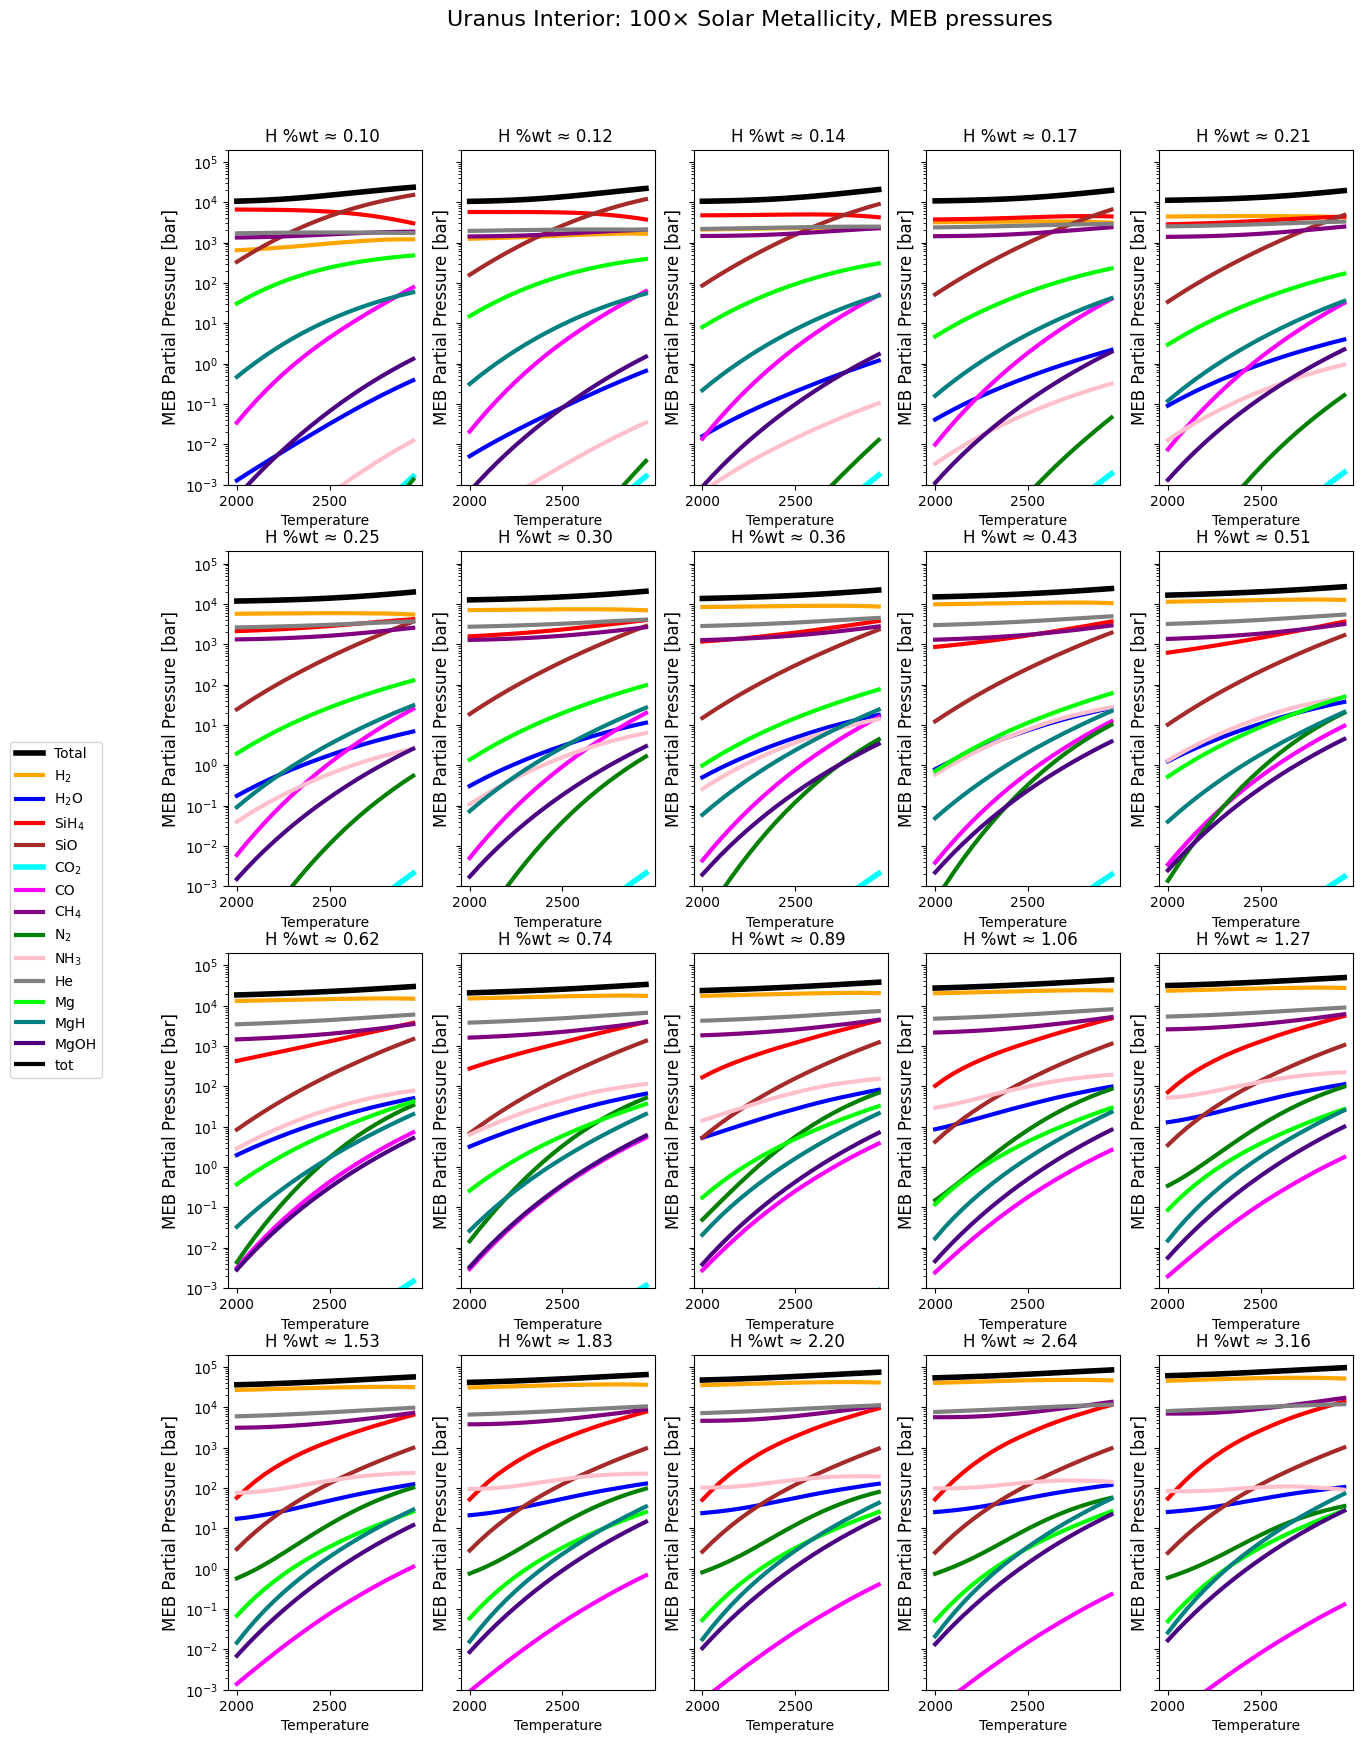

In [45]:
N = H_resolution
cols = 5
rows = (N + cols - 1) // cols


fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(H_resolution):
    indices = np.arange(T_resolution)
    values = i + indices * H_resolution
    values = np.array(values)
    Hwt = hmps[i]

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(temperature[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=4, ls="-", label="Total")
    ax.plot(temperature[values], H2_pressure_magma_sol_real[values], color=color_H2, lw=3, ls="-", label="H$_2$")
    ax.plot(temperature[values], H2O_pressure_magma_sol_real[values], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    ax.plot(temperature[values], SiH4_pressure_magma_sol_real[values], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    ax.plot(temperature[values], SiO_pressure_magma_sol_real[values], color=color_SiO, lw=3, ls="-", label="SiO")
    ax.plot(temperature[values], CO2_pressure_magma_sol_real[values], color=color_CO2, lw=4, ls="-", label="CO$_2$")
    ax.plot(temperature[values], CO_pressure_magma_sol_real[values], color=color_CO, lw=3, ls="-", label="CO")
    ax.plot(temperature[values], CH4_pressure_magma_sol_real[values], color=color_CH4, lw=3, ls="-", label="CH$_4$")
    ax.plot(temperature[values], N2_pressure_magma_sol_real[values], color=color_N2, lw=3, ls="-", label="N$_2$")
    ax.plot(temperature[values], NH3_pressure_magma_sol_real[values], color=color_NH3, lw=3, ls="-", label="NH$_3$")
    ax.plot(temperature[values], He_pressure_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(temperature[values], Mg_pressure_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")
    ax.plot(temperature[values], MgH_pressure_magma_sol_real[values], color=color_MgH, lw=3, ls="-", label="MgH")
    ax.plot(temperature[values], MgOH_pressure_magma_sol_real[values], color=color_MgOH, lw=3, ls="-", label="MgOH")
    ax.plot(temperature[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=3, ls="-", label="tot")

    ax.set_title(r"(a) Real gas")
    ax.set_ylim([1e-3, 2e5])
    ax.set_yscale("log")
    ax.set_xlabel(r"Temperature", fontsize=10)
    ax.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, H %wt ≈ {Hwt:.2f} "
    filename = f"./images_pressures3/uranus_{metall:.0f}xperc_{Hwt:.2f}.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(temperature[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=4, ls="-", label="Total")
    axes[i].plot(temperature[values], H2_pressure_magma_sol_real[values], color=color_H2, lw=3, ls="-", label="H$_2$")
    axes[i].plot(temperature[values], H2O_pressure_magma_sol_real[values], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    axes[i].plot(temperature[values], SiH4_pressure_magma_sol_real[values], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    axes[i].plot(temperature[values], SiO_pressure_magma_sol_real[values], color=color_SiO, lw=3, ls="-", label="SiO")
    axes[i].plot(temperature[values], CO2_pressure_magma_sol_real[values], color=color_CO2, lw=4, ls="-", label="CO$_2$")
    axes[i].plot(temperature[values], CO_pressure_magma_sol_real[values], color=color_CO, lw=3, ls="-", label="CO")
    axes[i].plot(temperature[values], CH4_pressure_magma_sol_real[values], color=color_CH4, lw=3, ls="-", label="CH$_4$")
    axes[i].plot(temperature[values], N2_pressure_magma_sol_real[values], color=color_N2, lw=3, ls="-", label="N$_2$")
    axes[i].plot(temperature[values], NH3_pressure_magma_sol_real[values], color=color_NH3, lw=3, ls="-", label="NH$_3$")
    axes[i].plot(temperature[values], He_pressure_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(temperature[values], Mg_pressure_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")
    axes[i].plot(temperature[values], MgH_pressure_magma_sol_real[values], color=color_MgH, lw=3, ls="-", label="MgH")
    axes[i].plot(temperature[values], MgOH_pressure_magma_sol_real[values], color=color_MgOH, lw=3, ls="-", label="MgOH")
    axes[i].plot(temperature[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=3, ls="-", label="tot")

    axes[i].set_title(f"H %wt ≈ {Hwt:.2f} ")
    axes[i].set_ylim([1e-3, 2e5])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Temperature", fontsize=10)
    axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, MEB pressures ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_pressures3/uranus_{metall:.0f}x.png", dpi=300, bbox_inches='tight')

## Plotting different things in function of hmps

In [46]:
N = T_resolution
cols = 5
rows = (N + cols - 1) // cols

2000.0
2050.0
2100.0
2150.0
2200.0
2250.0
2300.0
2350.0
2400.0
2450.0
2500.0
2550.0
2600.0
2650.0
2700.0
2750.0
2800.0
2850.0
2900.0
2950.0


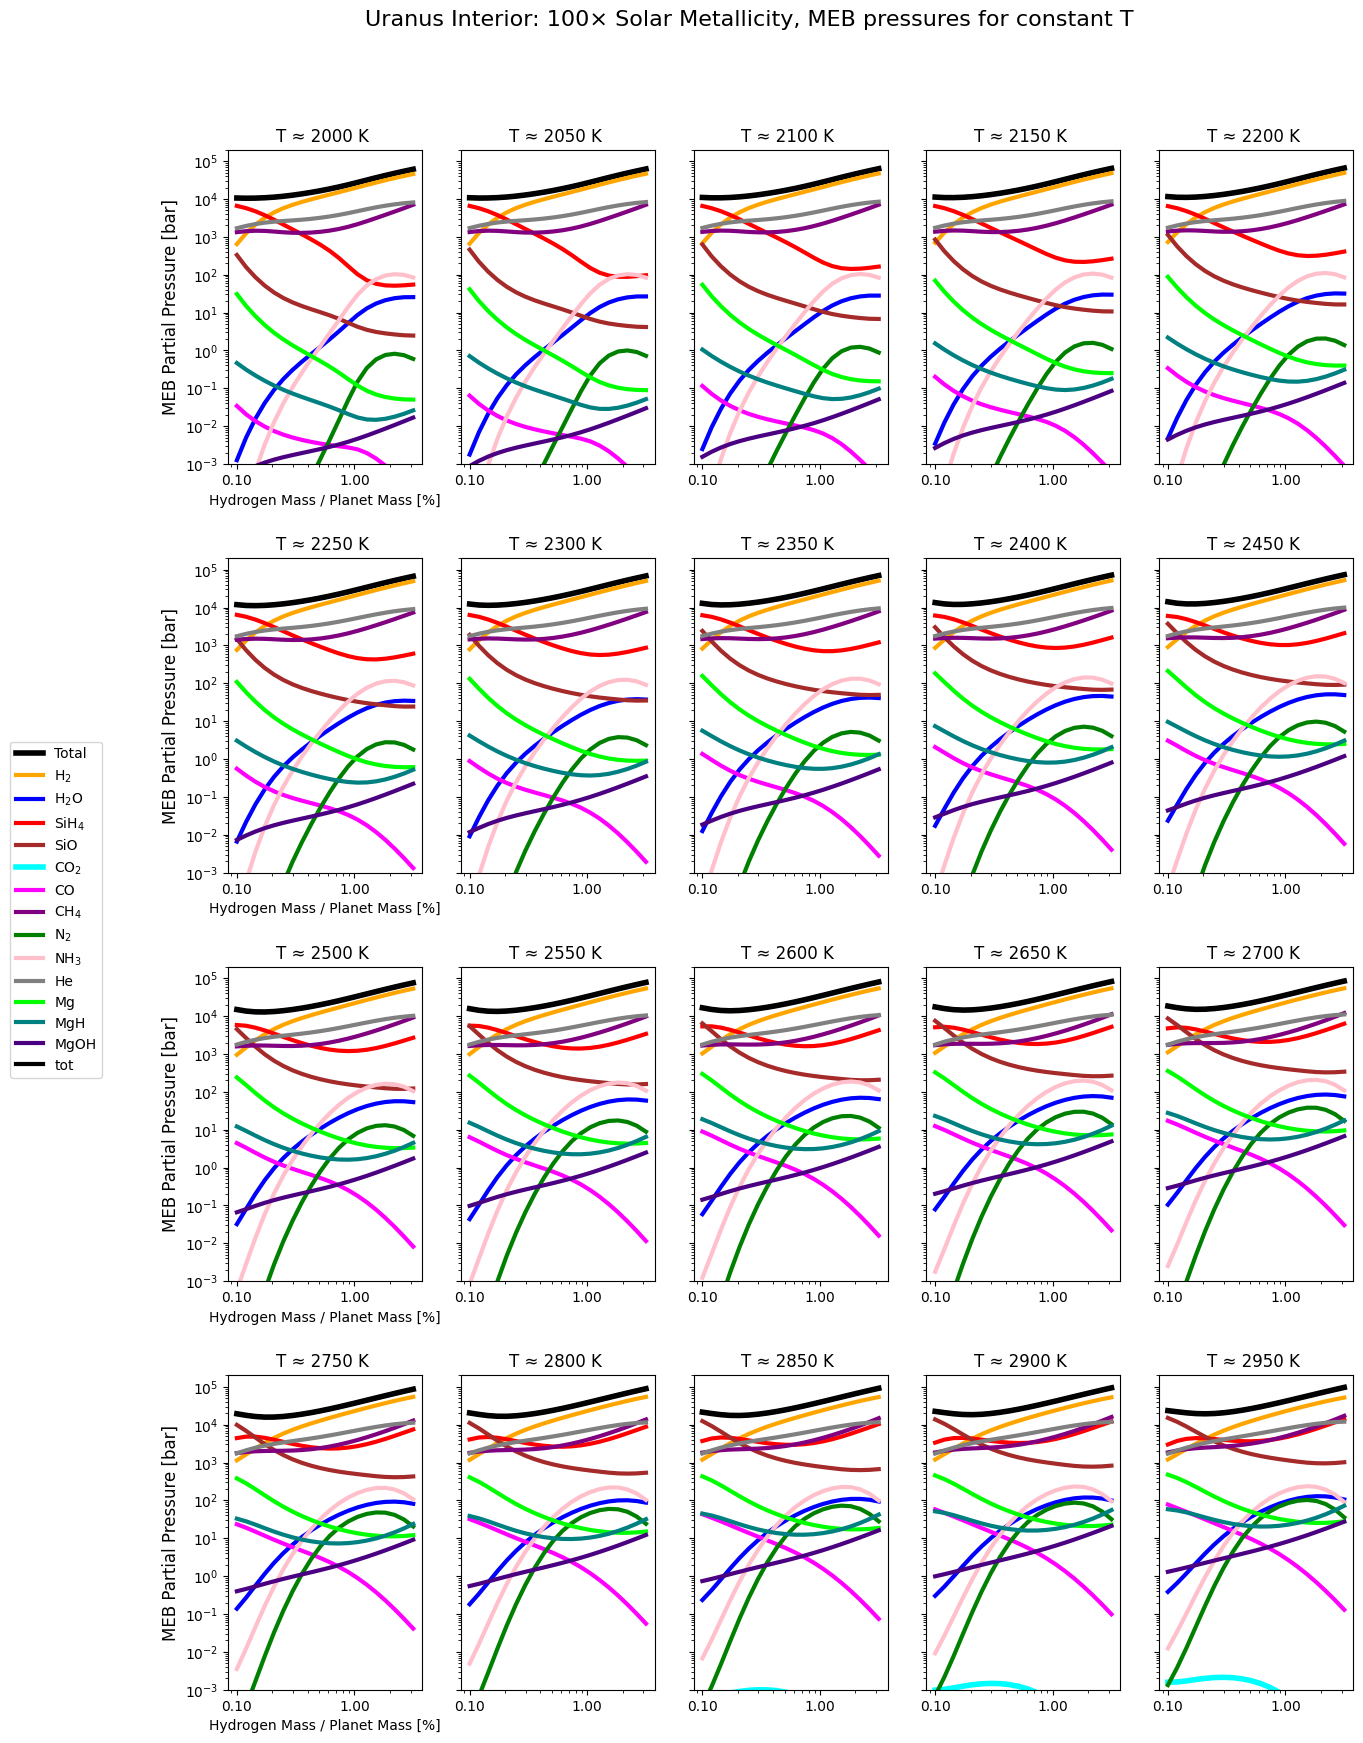

In [47]:
#MEB partial pressure 
fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(T_resolution):
    values = list(range(i*H_resolution, i*H_resolution + H_resolution))
    Temp = temperature[i*H_resolution]
    print(Temp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(hmps[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=4, ls="-", label="Total")
    ax.plot(hmps[values], H2_pressure_magma_sol_real[values], color=color_H2, lw=3, ls="-", label="H$_2$")
    ax.plot(hmps[values], H2O_pressure_magma_sol_real[values], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    ax.plot(hmps[values], SiH4_pressure_magma_sol_real[values], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    ax.plot(hmps[values], SiO_pressure_magma_sol_real[values], color=color_SiO, lw=3, ls="-", label="SiO")
    ax.plot(hmps[values], CO2_pressure_magma_sol_real[values], color=color_CO2, lw=4, ls="-", label="CO$_2$")
    ax.plot(hmps[values], CO_pressure_magma_sol_real[values], color=color_CO, lw=3, ls="-", label="CO")
    ax.plot(hmps[values], CH4_pressure_magma_sol_real[values], color=color_CH4, lw=3, ls="-", label="CH$_4$")
    ax.plot(hmps[values], N2_pressure_magma_sol_real[values], color=color_N2, lw=3, ls="-", label="N$_2$")
    ax.plot(hmps[values], NH3_pressure_magma_sol_real[values], color=color_NH3, lw=3, ls="-", label="NH$_3$")
    ax.plot(hmps[values], He_pressure_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(hmps[values], Mg_pressure_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")
    ax.plot(hmps[values], MgH_pressure_magma_sol_real[values], color=color_MgH, lw=3, ls="-", label="MgH")
    ax.plot(hmps[values], MgOH_pressure_magma_sol_real[values], color=color_MgOH, lw=3, ls="-", label="MgOH")
    ax.plot(hmps[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=3, ls="-", label="tot")

    ax.set_title(r"(a) Real gas")
    ax.set_ylim([1e-3, 2e5])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    ax.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {Temp:.0f} K"
    filename = f"./images_pressures3/uranus_{metall:.0f}xT_{Temp:.0f}K.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(hmps[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=4, ls="-", label="Total")
    axes[i].plot(hmps[values], H2_pressure_magma_sol_real[values], color=color_H2, lw=3, ls="-", label="H$_2$")
    axes[i].plot(hmps[values], H2O_pressure_magma_sol_real[values], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    axes[i].plot(hmps[values], SiH4_pressure_magma_sol_real[values], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    axes[i].plot(hmps[values], SiO_pressure_magma_sol_real[values], color=color_SiO, lw=3, ls="-", label="SiO")
    axes[i].plot(hmps[values], CO2_pressure_magma_sol_real[values], color=color_CO2, lw=4, ls="-", label="CO$_2$")
    axes[i].plot(hmps[values], CO_pressure_magma_sol_real[values], color=color_CO, lw=3, ls="-", label="CO")
    axes[i].plot(hmps[values], CH4_pressure_magma_sol_real[values], color=color_CH4, lw=3, ls="-", label="CH$_4$")
    axes[i].plot(hmps[values], N2_pressure_magma_sol_real[values], color=color_N2, lw=3, ls="-", label="N$_2$")
    axes[i].plot(hmps[values], NH3_pressure_magma_sol_real[values], color=color_NH3, lw=3, ls="-", label="NH$_3$")
    axes[i].plot(hmps[values], He_pressure_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(hmps[values], Mg_pressure_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")
    axes[i].plot(hmps[values], MgH_pressure_magma_sol_real[values], color=color_MgH, lw=3, ls="-", label="MgH")
    axes[i].plot(hmps[values], MgOH_pressure_magma_sol_real[values], color=color_MgOH, lw=3, ls="-", label="MgOH")
    axes[i].plot(hmps[values], tot_pressure_magma_sol_real[values], color=color_tot, lw=3, ls="-", label="tot")

    axes[i].set_title(f"T ≈ {Temp:.0f} K ")
    axes[i].set_ylim([1e-3, 2e5])
    axes[i].set_ylim([1e-3, 2e5])
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    #axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    #axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 

    if i % cols ==0:
        axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
        axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)

# Adjust spacing
fig_big.subplots_adjust(hspace=0.3, wspace=0.2)
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, MEB pressures for constant T ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_pressures3/uranus_{metall:.0f}x_constantT_MEBpressure.png", dpi=300, bbox_inches='tight')

2000.0
2050.0
2100.0
2150.0
2200.0
2250.0
2300.0
2350.0
2400.0
2450.0
2500.0
2550.0
2600.0
2650.0
2700.0
2750.0
2800.0
2850.0
2900.0
2950.0


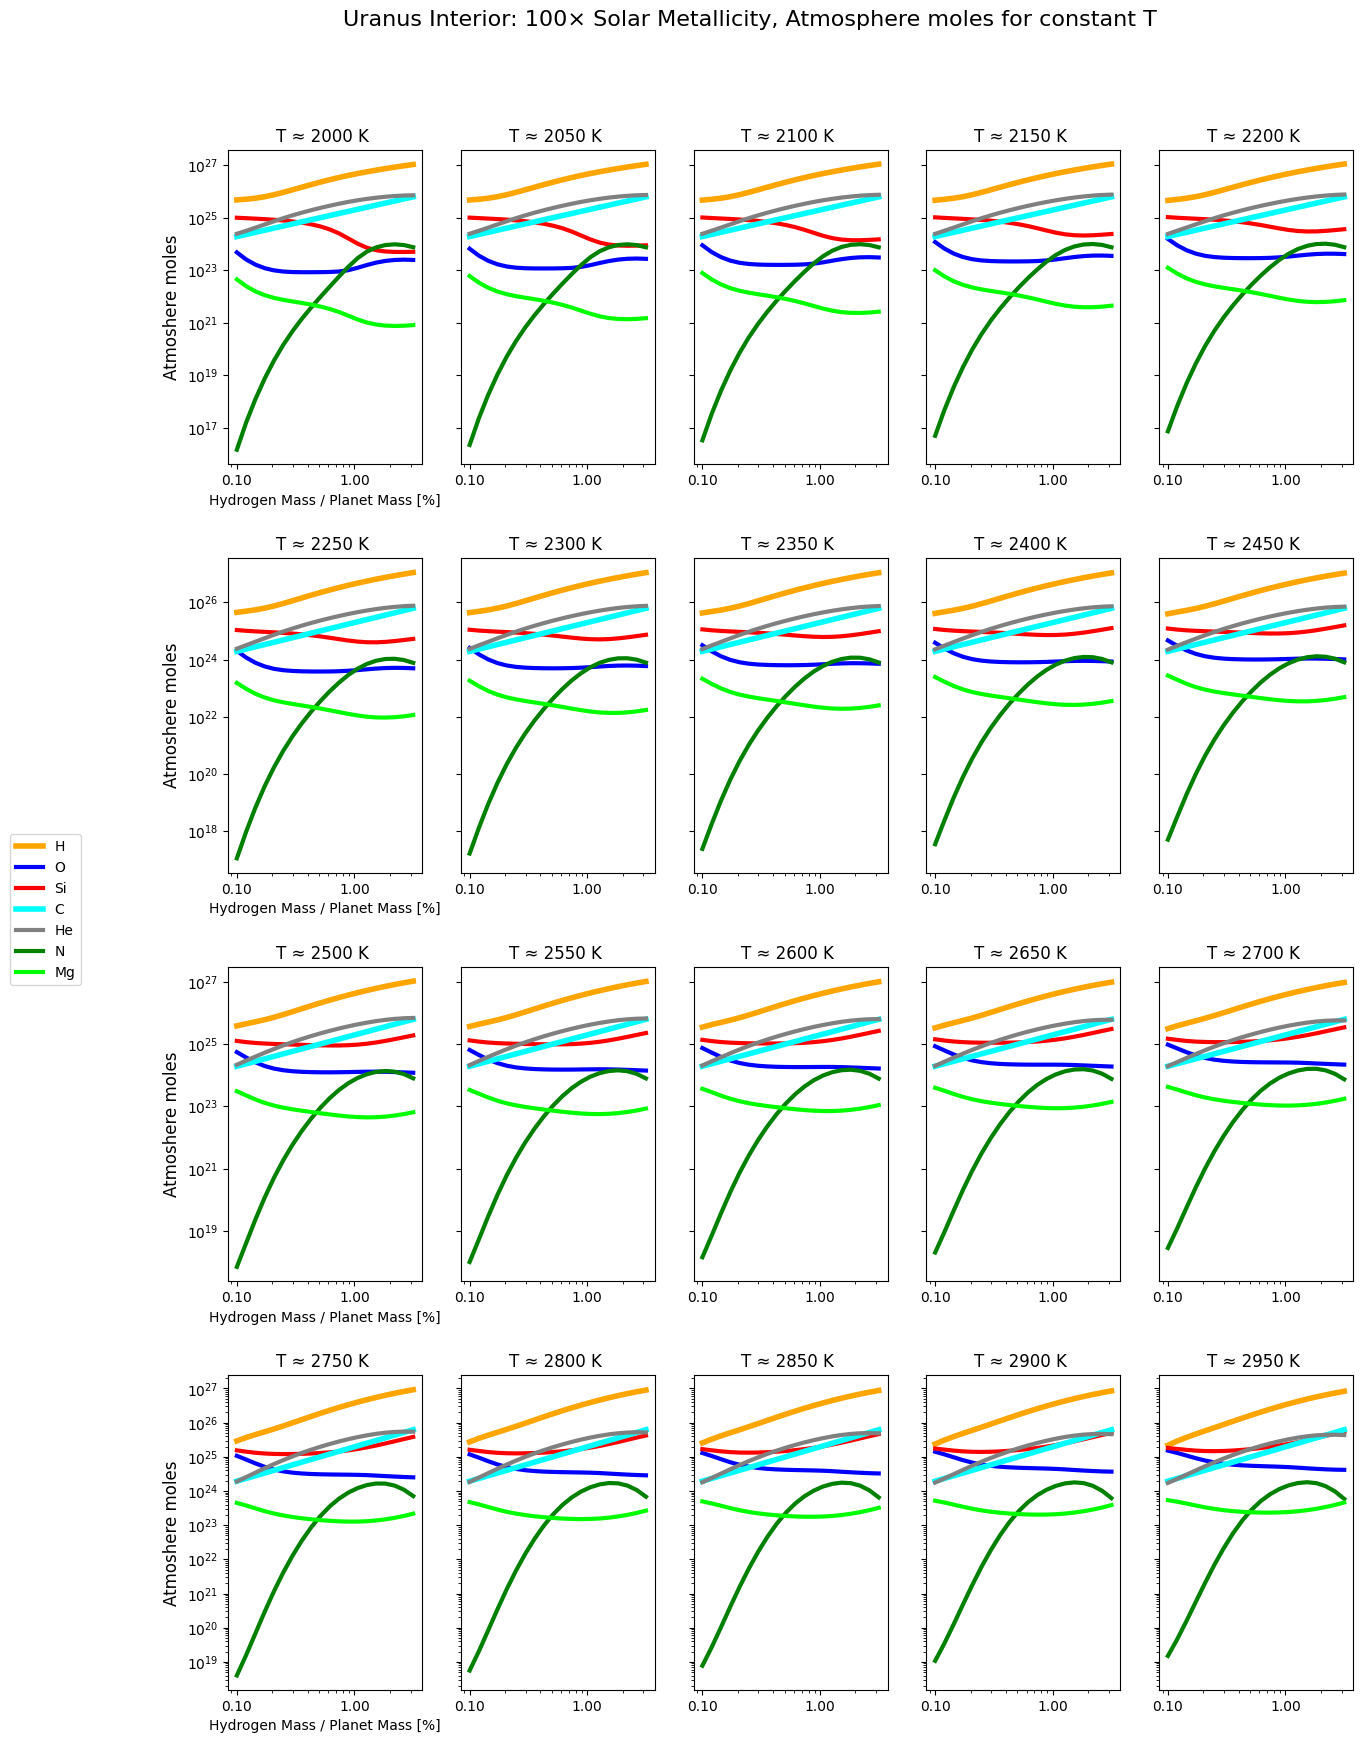

In [48]:
#atmosphere moles
fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(T_resolution):
    values = list(range(i*H_resolution, i*H_resolution + H_resolution))
    Temp = temperature[i*H_resolution]
    print(Temp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(hmps[values], H_moles_atm_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    ax.plot(hmps[values], O_moles_atm_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    ax.plot(hmps[values], Si_moles_atm_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(hmps[values], C_moles_atm_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    ax.plot(hmps[values], He_moles_atm_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(hmps[values], N_moles_atm_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    ax.plot(hmps[values], Mg_moles_atm_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    ax.set_title(r"(a) Real gas")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    ax.set_ylabel(r"Atmosphere moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {Temp:.0f} K"
    filename = f"./images_batch/uranus_{metall:.0f}xT_{Temp:.0f}K_Atmosphere_Moles.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(hmps[values], H_moles_atm_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(hmps[values], O_moles_atm_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    axes[i].plot(hmps[values], Si_moles_atm_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(hmps[values], C_moles_atm_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    axes[i].plot(hmps[values], He_moles_atm_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(hmps[values], N_moles_atm_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    axes[i].plot(hmps[values], Mg_moles_atm_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    axes[i].set_title(f"T ≈ {Temp:.0f} K ")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    #axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    #axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 

    if i % cols ==0:
        axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
        axes[i].set_ylabel(r"Atmoshere moles", fontsize=12)

# Adjust spacing
fig_big.subplots_adjust(hspace=0.3, wspace=0.2)
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, Atmosphere moles for constant T ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_batch/uranus_{metall:.0f}x_constantT_Atmosphere_Moles.png", dpi=300, bbox_inches='tight')

2000.0
2050.0
2100.0
2150.0
2200.0
2250.0
2300.0
2350.0
2400.0
2450.0
2500.0
2550.0
2600.0
2650.0
2700.0
2750.0
2800.0
2850.0
2900.0
2950.0


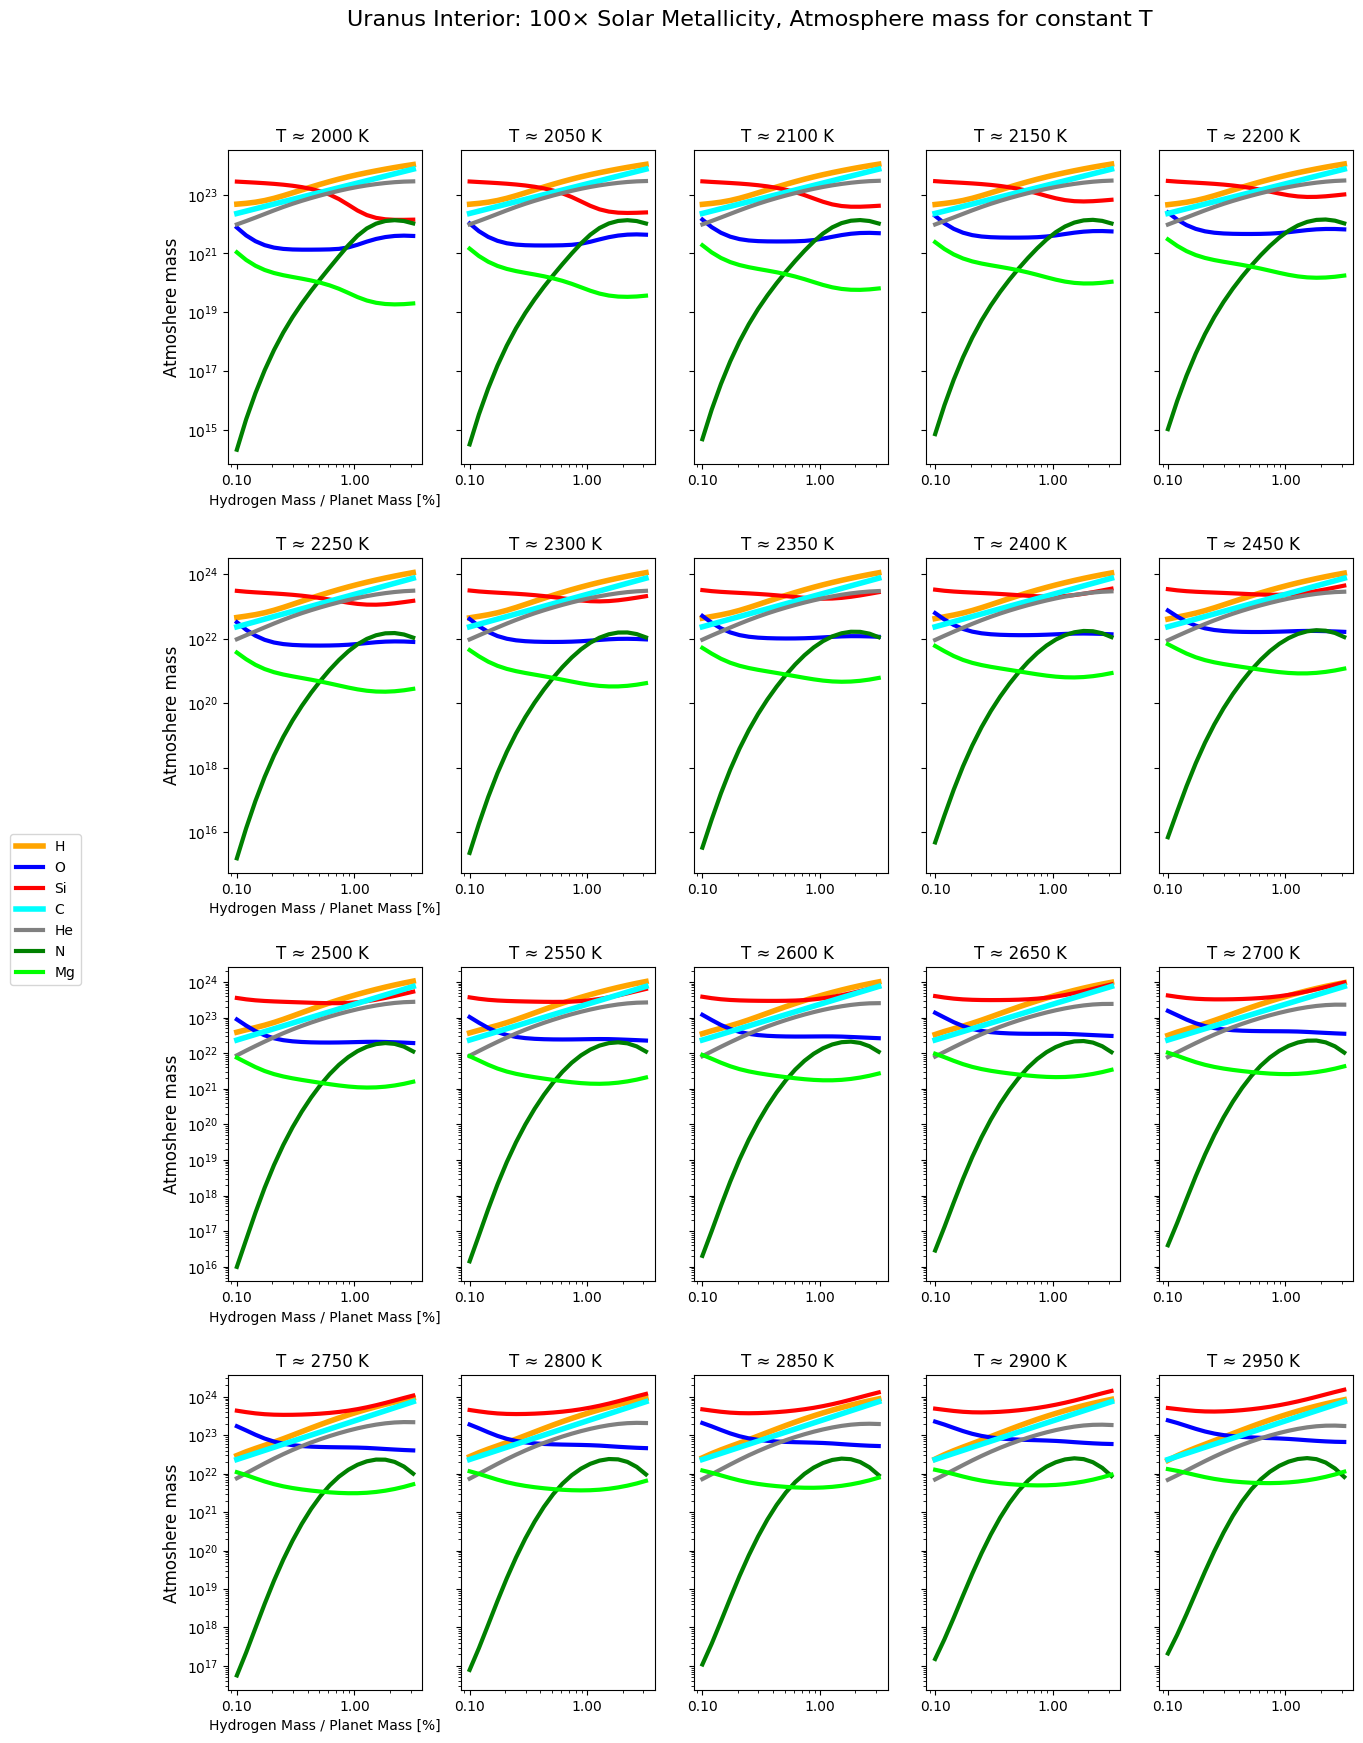

In [49]:
#atmosphere mass
fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(T_resolution):
    values = list(range(i*H_resolution, i*H_resolution + H_resolution))
    Temp = temperature[i*H_resolution]
    print(Temp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(hmps[values], H_mass_atm_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    ax.plot(hmps[values], O_mass_atm_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    ax.plot(hmps[values], Si_mass_atm_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(hmps[values], C_mass_atm_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    ax.plot(hmps[values], He_mass_atm_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(hmps[values], N_mass_atm_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    ax.plot(hmps[values], Mg_mass_atm_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    ax.set_title(r"(a) Real gas")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    ax.set_ylabel(r"Atmosphere mass", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {Temp:.0f} K"
    filename = f"./images_batch/uranus_{metall:.0f}xT_{Temp:.0f}K_Atmosphere_Mass.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(hmps[values], H_mass_atm_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(hmps[values], O_mass_atm_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    axes[i].plot(hmps[values], Si_mass_atm_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(hmps[values], C_mass_atm_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    axes[i].plot(hmps[values], He_mass_atm_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(hmps[values], N_mass_atm_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    axes[i].plot(hmps[values], Mg_mass_atm_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    axes[i].set_title(f"T ≈ {Temp:.0f} K ")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    #axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    #axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 

    if i % cols ==0:
        axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
        axes[i].set_ylabel(r"Atmoshere mass", fontsize=12)

# Adjust spacing
fig_big.subplots_adjust(hspace=0.3, wspace=0.2)
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, Atmosphere mass for constant T ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_batch/uranus_{metall:.0f}x_constantT_Atmosphere_Mass.png", dpi=300, bbox_inches='tight')

2000.0
2050.0
2100.0
2150.0
2200.0
2250.0
2300.0
2350.0
2400.0
2450.0
2500.0
2550.0
2600.0
2650.0
2700.0
2750.0
2800.0
2850.0
2900.0
2950.0


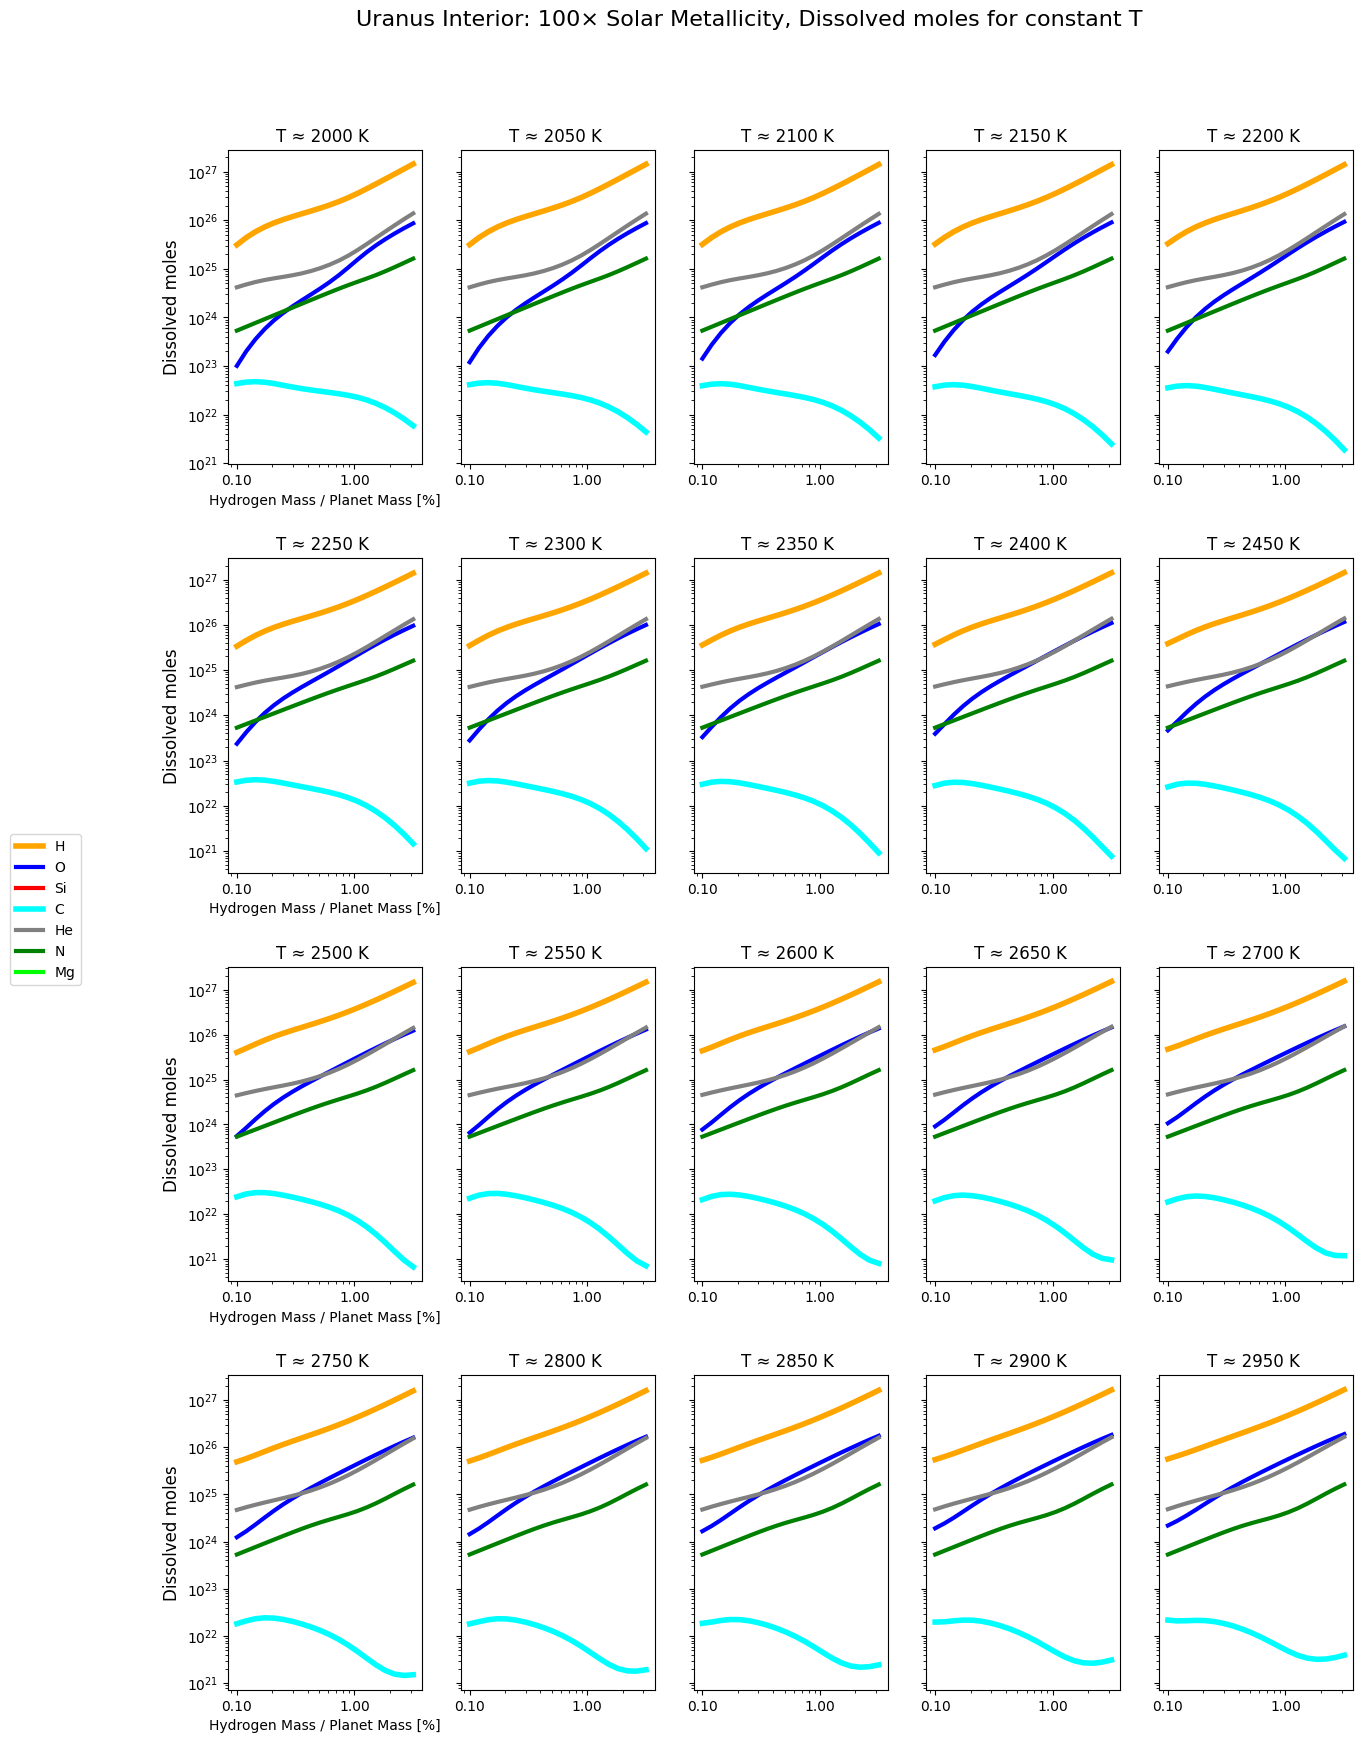

In [50]:
#dissolved moles
fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(T_resolution):
    values = list(range(i*H_resolution, i*H_resolution + H_resolution))
    Temp = temperature[i*H_resolution]
    print(Temp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(hmps[values], H_moles_melt_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    ax.plot(hmps[values], O_moles_melt_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    ax.plot(hmps[values], Si_moles_melt_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(hmps[values], C_moles_melt_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    ax.plot(hmps[values], He_moles_melt_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(hmps[values], N_moles_melt_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    ax.plot(hmps[values], Mg_moles_melt_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    ax.set_title(r"(a) Real gas")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    ax.set_ylabel(r"Dissolved moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {Temp:.0f} K"
    filename = f"./images_batch/uranus_{metall:.0f}xT_{Temp:.0f}K_Dissolved_Moles.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(hmps[values], H_moles_melt_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(hmps[values], O_moles_melt_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    axes[i].plot(hmps[values], Si_moles_melt_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(hmps[values], C_moles_melt_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    axes[i].plot(hmps[values], He_moles_melt_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(hmps[values], N_moles_melt_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    axes[i].plot(hmps[values], Mg_moles_melt_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    axes[i].set_title(f"T ≈ {Temp:.0f} K ")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    #axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    #axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 

    if i % cols ==0:
        axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
        axes[i].set_ylabel(r"Dissolved moles", fontsize=12)

# Adjust spacing
fig_big.subplots_adjust(hspace=0.3, wspace=0.2)
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, Dissolved moles for constant T ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_batch/uranus_{metall:.0f}x_constantT_Dissolved_Moles.png", dpi=300, bbox_inches='tight')

2000.0
2050.0
2100.0
2150.0
2200.0
2250.0
2300.0
2350.0
2400.0
2450.0
2500.0
2550.0
2600.0
2650.0
2700.0
2750.0
2800.0
2850.0
2900.0
2950.0


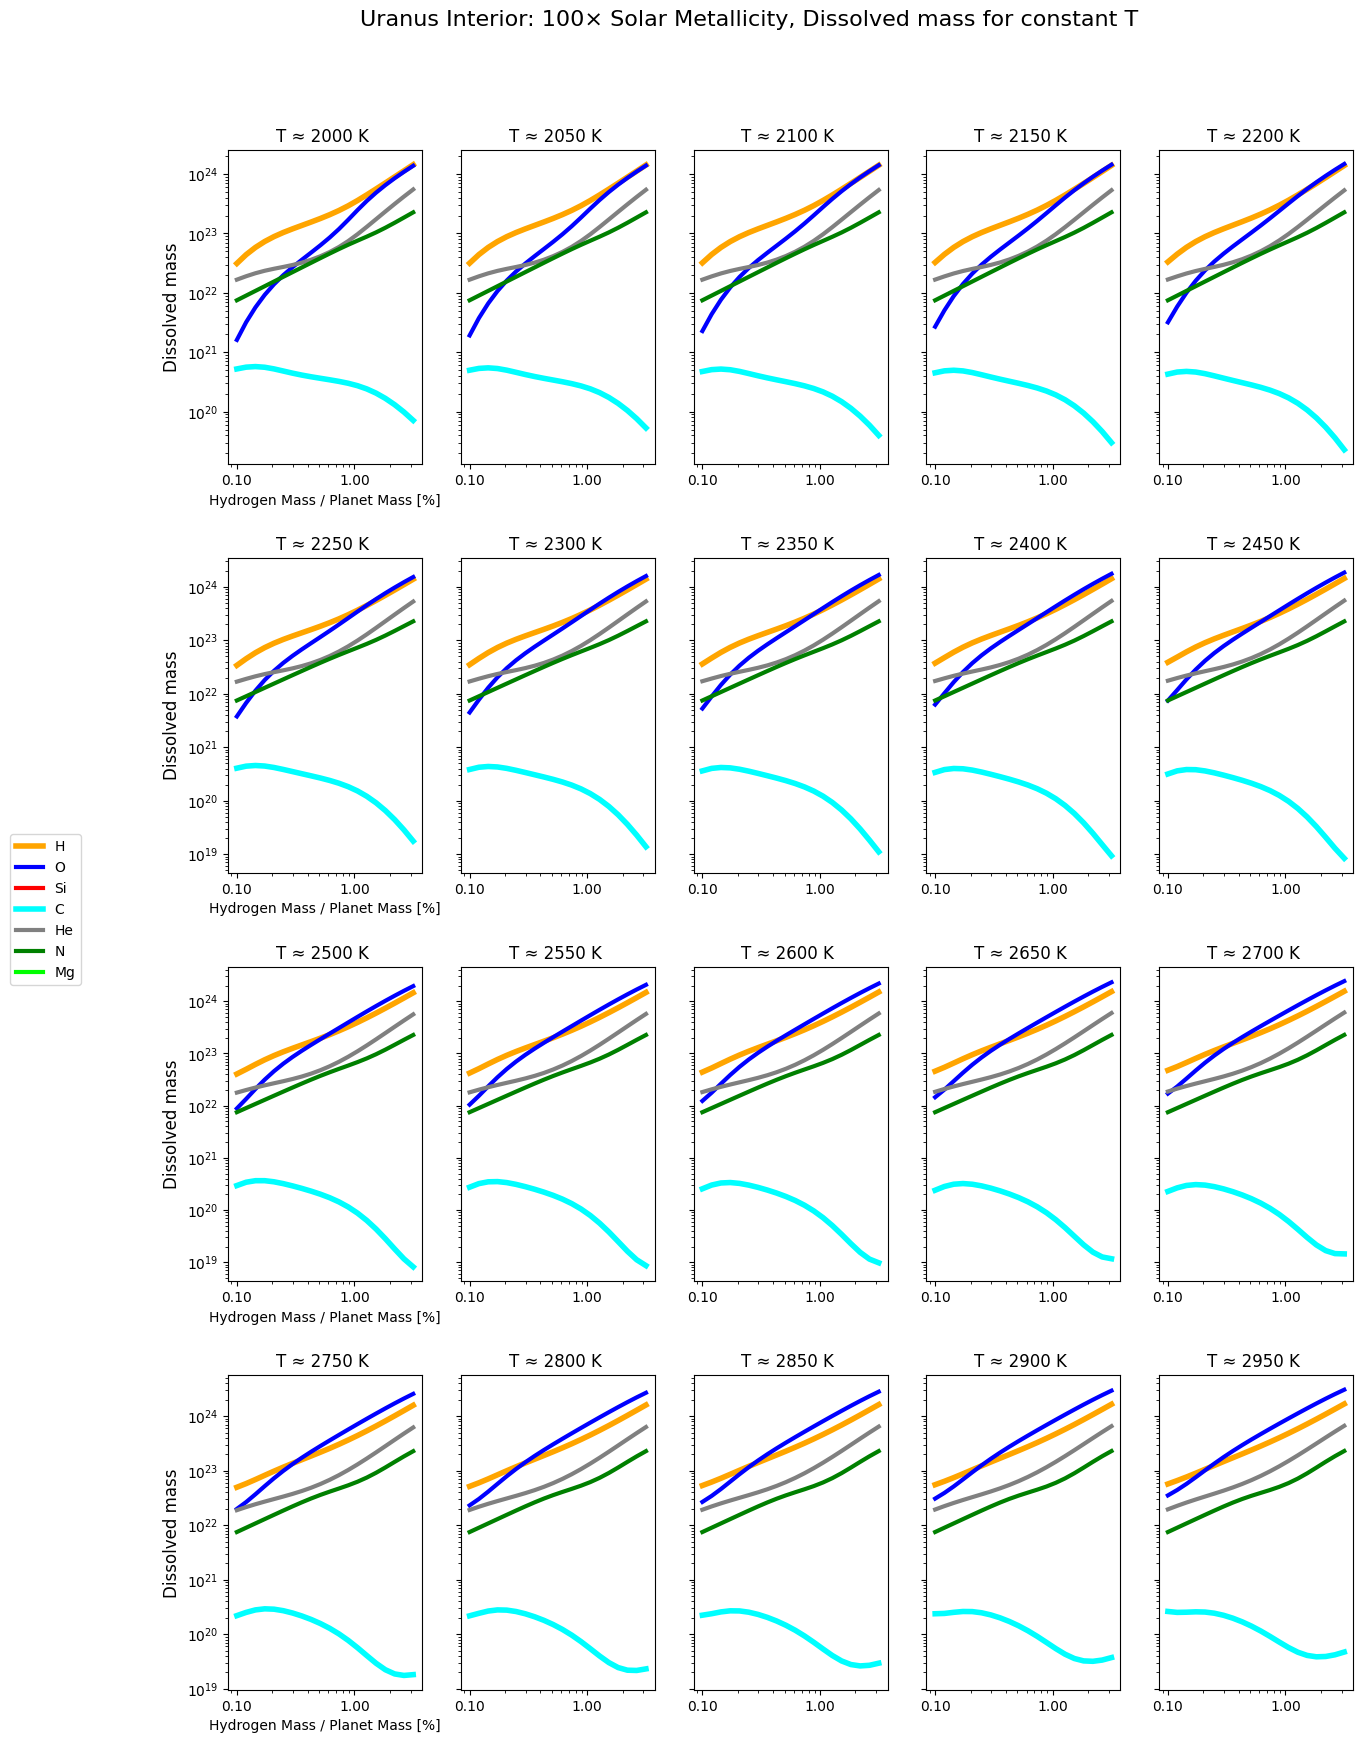

In [51]:
#dissolved mass
fig_big, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None

for i in range(T_resolution):
    values = list(range(i*H_resolution, i*H_resolution + H_resolution))
    Temp = temperature[i*H_resolution]
    print(Temp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(hmps[values], H_mass_melt_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    ax.plot(hmps[values], O_mass_melt_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    ax.plot(hmps[values], Si_mass_melt_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(hmps[values], C_mass_melt_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    ax.plot(hmps[values], He_mass_melt_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    ax.plot(hmps[values], N_mass_melt_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    ax.plot(hmps[values], Mg_mass_melt_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    ax.set_title(r"(a) Real gas")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    ax.set_ylabel(r"Dissolved moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: {metall:.0f}× Solar Metallicity, T ≈ {Temp:.0f} K"
    filename = f"./images_batch/uranus_{metall:.0f}xT_{Temp:.0f}K_Dissolved_Mass.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(hmps[values], H_mass_melt_magma_sol_real[values], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(hmps[values], O_mass_melt_magma_sol_real[values], color=color_O, lw=3, ls="-", label="O")
    axes[i].plot(hmps[values], Si_mass_melt_magma_sol_real[values], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(hmps[values], C_mass_melt_magma_sol_real[values], color=color_C, lw=4, ls="-", label="C")
    axes[i].plot(hmps[values], He_mass_melt_magma_sol_real[values], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(hmps[values], N_mass_melt_magma_sol_real[values], color=color_N, lw=3, ls="-", label="N")
    axes[i].plot(hmps[values], Mg_mass_melt_magma_sol_real[values], color=color_Mg, lw=3, ls="-", label="Mg")

    axes[i].set_title(f"T ≈ {Temp:.0f} K ")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    #axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
    #axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 

    if i % cols ==0:
        axes[i].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
        axes[i].set_ylabel(r"Dissolved mass", fontsize=12)

# Adjust spacing
fig_big.subplots_adjust(hspace=0.3, wspace=0.2)
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: {metall:.0f}× Solar Metallicity, Dissolved mass for constant T ", fontsize=16, y=0.95) 
fig_big.savefig(f"./images_batch/uranus_{metall:.0f}x_constantT_Dissolved_Mass.png", dpi=300, bbox_inches='tight')